# Pulsar Timing Analysis

Welcome to our step-by-step Jupyter notebook tutorial on pulsar timing analysis using the TAT-Pulsar Python package.

Throughout this guide, we'll provide you with hands-on examples of how to use the key features of TAT-Pulsar. 

## Search the best frequency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import wget, os
from astropy.io import fits

mpl.rcParams['figure.dpi'] = 250
plt.style.use(['science', 'nature', 'no-latex'])

np.random.seed(19930727)

In [2]:
test_data_url = "https://zenodo.org/record/6785435/files/NICER_Crab_data.gz?download=1"
test_orbit_url = "https://zenodo.org/record/6785435/files/NICER_Crab_orb.gz?download=1"
# The real data are Crab data observed by NICER. 
# The size of event file is 170MB.

test_file = "NICER_Crab_data.gz"
orbit_file = "NICER_Crab_orb.gz"
if not os.path.exists(test_file):
    print("Downloading the test datab")
    wget.download(test_data_url)
    wget.download(test_orbit_url)
else:
    print(f"The test data '{test_file}' is already downloaded!")    

The test data 'NICER_Crab_data.gz' is already downloaded!


## Bayrcentric correction

Read the events data from FITS file

In [3]:
hdulist = fits.open(test_file)
time = hdulist['EVENTS'].data['TIME']
time = time + hdulist['EVENTS'].header['TIMEZERO'] # NICER Time system correction

Retrieve the parameters from Jodrell Bank Crab monitoring website: http://www.jb.man.ac.uk/~pulsar/crab/all.gro 

Then write the parameter table into a local file 'Crab.gro', and get the Crab timing parameters covering the observed data.

In [4]:
from tatpulsar.pulse.Crab.retrive_eph import retrieve_ephemeris, get_par
from tatpulsar.utils.functions import met2mjd

eph = retrieve_ephemeris(write_to_file=True, ephfile='Crab.gro')
par = get_par( met2mjd(time[0], telescope='nicer'), eph)
print(par)

/Users/tuoyouli/anaconda3/lib/python3.7/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


PSR_B       0531+21
RA_hh             5
RA_mm            34
RA_ss        31.972
DEC_hh           22
DEC_mm            0
DEC_ss        52.07
MJD1          57966
MJD2          57997
t0geo       57981.0
f0        29.639378
f1             -0.0
f2              0.0
RMS             0.6
O                 J
B             DE200
name        0531+21
Notes           NaN
Name: 374, dtype: object


----------
According to the GRO parameter provided by Jodrell Bank, the reference time of timing parameters is the integer part of the `t0geo`, `t0geo` is the time of arrival of radio pulse measured at the geometric center of the Earth (in UTC time system). So We convert the `t0geo` to the barycenter of the solar system and calculate the phase of it as `phi0` (convert UTC to TT first).

If we want to compare the absolute phase and the phase lag of the profile with the radio (and we usually compare the phase main peak with the Jodrell Bank main peak), we shift the profiles with `phi0`, and it appears to locate near the phase one.


In [5]:
from tatpulsar.pulse.barycor.barycor import barycor
from tatpulsar.pulse.fold import cal_phase
from astropy.time import Time

# barycentric correction on t0geo
t0tt = Time(par.t0geo, format='mjd', scale='utc').tt.to_value(format='mjd')
t0bary = barycor(t0tt, ra=83.63321666666667, dec=22.01446388888889)

phi0 = cal_phase(t0bary, pepoch=int(par.t0geo),
                 f0=par.f0, f1=par.f1, f2=par.f2,
                format='mjd')

print(f"the main peak of radio pulse is {phi0}.")

the main peak of radio pulse is 0.7807356869125215.


Now we calculate the barycentric correction on each photon.

In [6]:
# barycor only support time in MJD
from tatpulsar.utils.functions import met2mjd, mjd2met

time_mjd = met2mjd(time, telescope='nicer')
tdb_mjd = barycor(time_mjd, ra=83.63321666666667, dec=22.01446388888889,
              orbit=orbit_file, accelerate=True)

# convert the TDB in MJD into MET system
tdb = mjd2met(tdb_mjd, telescope='nicer')

Accelerating barycor


Now we calculate the phase for each photon, and fold the profile, using the function `tatpulsar.pulse.fold.fold`.

Text(0, 0.5, 'Counts')

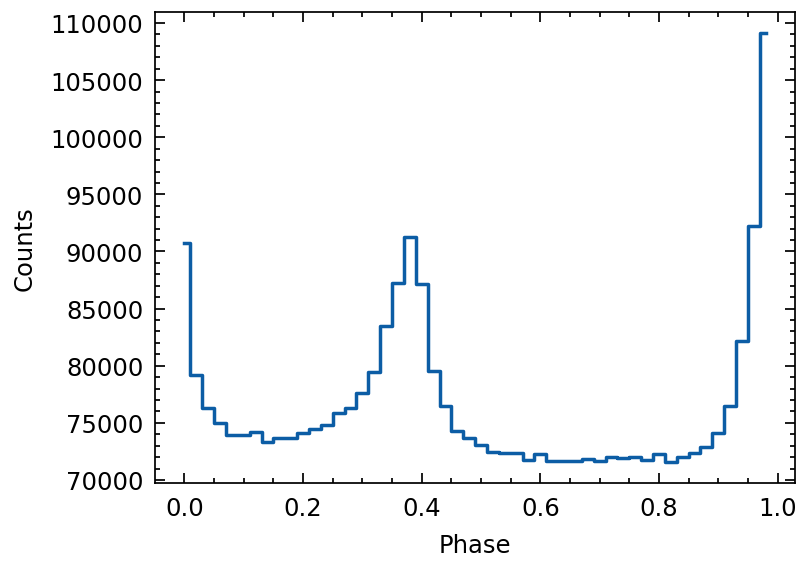

In [7]:
from tatpulsar.pulse.fold import fold
from tatpulsar.data.profile import Profile

profile = fold(tdb, f0=par.f0, f1=par.f1, f2=par.f2,
                   pepoch=mjd2met(int(par.t0geo), telescope='nicer'),
                   nbins=50, phi0=phi0)

plt.errorbar(profile.phase, profile.counts, ds='steps-mid')
plt.xlabel("Phase")
plt.ylabel("Counts")

## Play with the profile

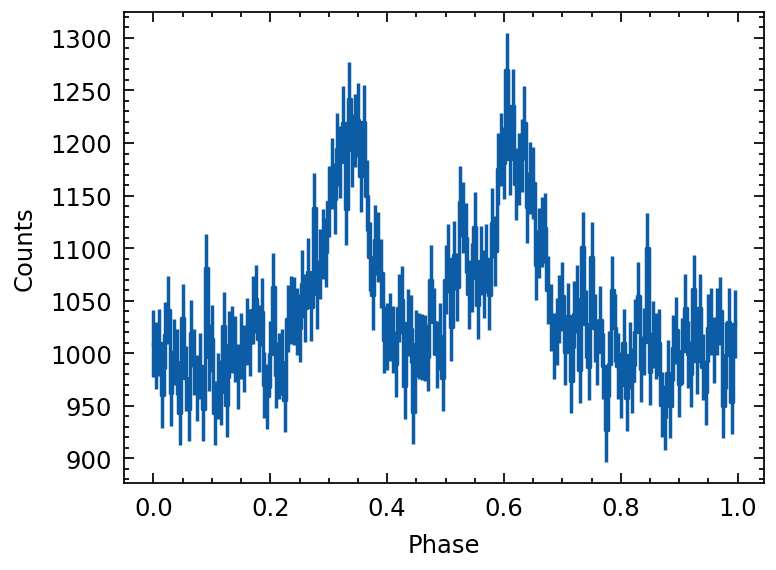

In [8]:
## Generate a random pulse profile that consists of multiple Gaussian-like pulse

def draw_random_pulse(nbins=100, baseline=1000, pulsefrac=0.2):
    # Define the time array
    phase = np.linspace(0, 1, nbins)  

    # Define a random number of pulses
    num_pulses = np.random.randint(4, 10)

    # Initialize the signal
    signal = np.zeros_like(phase)

    # Generate the signal by summing up the pulses
    for _ in range(num_pulses):
        # Randomly generate the Gaussian pulse parameters
        amp = np.random.uniform(0.1, 1.0)  # Amplitude of pulse
        mu = np.random.uniform(0.2, 0.8)  # Mean (peak location within 0 to 2)
        sigma = np.random.uniform(0.01, 0.1)  # Standard deviation (controls width of pulse)

        # Generate the Gaussian pulse
        pulse = amp * np.exp(-(phase - mu)**2 / (2 * sigma**2))

        # Add the pulse to the signal
        signal += pulse
        
    signal = signal/signal.max()

    pmax = baseline*(1+pulsefrac)/(1-pulsefrac)
    scale = pmax - baseline
    signal = signal*scale + baseline
    
    signal = np.random.poisson(signal) # poisson sampling

    return Profile(signal)

def plot_profile(profile):
    plt.errorbar(profile.phase, profile.counts,
                 profile.error,
                 ds='steps-mid')
    plt.xlabel("Phase")
    plt.ylabel("Counts")

profile = draw_random_pulse(nbins=200, baseline=1000, pulsefrac=0.1)
plot_profile(profile)

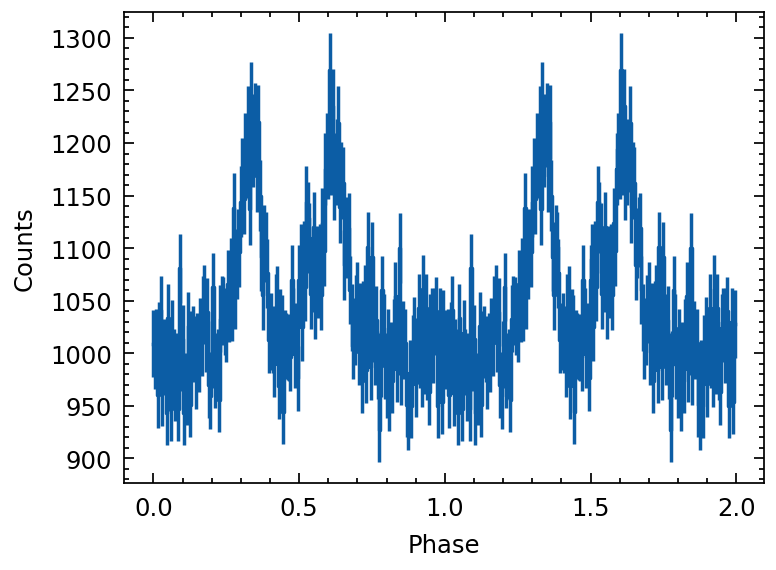

In [9]:
profile.cycles = 2 # set the phase cycls of profile
plot_profile(profile)

### Rebining
rebin the initial profile into a new bin size.

/Users/tuoyouli/Work/SoftwareDev/tatpulsar/tat-pulsar_main/tatpulsar/data/profile.py:343: RuntimeWarning: divide by zero encountered in true_divide
  norm_error = expression * np.sqrt((delta_num / (X - m))**2 + (delta_den / (M - m))**2)
/Users/tuoyouli/Work/SoftwareDev/tatpulsar/tat-pulsar_main/tatpulsar/data/profile.py:343: RuntimeWarning: invalid value encountered in multiply
  norm_error = expression * np.sqrt((delta_num / (X - m))**2 + (delta_den / (M - m))**2)
/Users/tuoyouli/Work/SoftwareDev/tatpulsar/tat-pulsar_main/tatpulsar/data/profile.py:343: RuntimeWarning: divide by zero encountered in true_divide
  norm_error = expression * np.sqrt((delta_num / (X - m))**2 + (delta_den / (M - m))**2)
/Users/tuoyouli/Work/SoftwareDev/tatpulsar/tat-pulsar_main/tatpulsar/data/profile.py:343: RuntimeWarning: invalid value encountered in multiply
  norm_error = expression * np.sqrt((delta_num / (X - m))**2 + (delta_den / (M - m))**2)


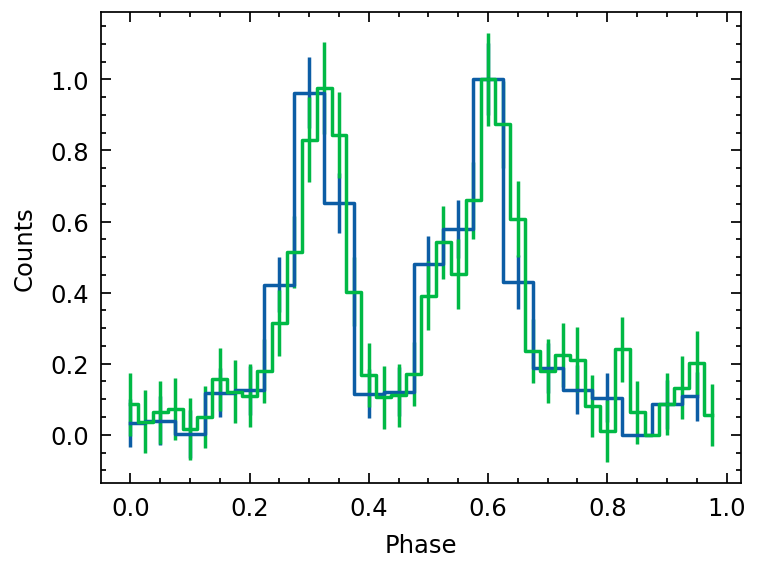

In [10]:
profile.cycles=1 # restore the original cycles of the profile
profile_tmp = profile.rebin(factor=10, return_profile=True)
profile_tmp.norm() # Normalization
plot_profile(profile_tmp)

#--------- Use second rebin profile
profile_tmp = profile.rebin(nbins=40, return_profile=True)
profile_tmp.norm()
plot_profile(profile_tmp)

### pulse fraction
The algorithm of calculating pulse fraction is:

$$ PF = (p_{\mathrm{max}} - p_{\mathrm{min}})/(p_{\mathrm{max}} + p_{\mathrm{min}})$$

where `p` is the counts of profile, please note the pulse fraction has valid physical meaning only if the input profile is folded by the net lightcurve or the background level can be well estimated and subtracted from the observed pulse profile.

In [11]:
pf, pf_err = profile.pulsefrac
print(f"Pulse frac= {pf} +- {pf_err}")

Pulse frac= 0.1557377049180328 +- 0.021079105142742433


### Significance
We are deal with two-tailed tests here

In [12]:
print(profile.significance)

20.807357666592512


### Normalization methods
we test two ways of normlizing the profile here
1. `method = 0` : $$ N = (P - P_{\mathrm{min}})/(P_{\mathrm{max}} - P_{\mathrm{min}}) $$
2. `method = 1` : $$ N = (P-P_{\mathrm{min}})/\bar{P} $$

/Users/tuoyouli/Work/SoftwareDev/tatpulsar/tat-pulsar_main/tatpulsar/data/profile.py:343: RuntimeWarning: divide by zero encountered in true_divide
  norm_error = expression * np.sqrt((delta_num / (X - m))**2 + (delta_den / (M - m))**2)
/Users/tuoyouli/Work/SoftwareDev/tatpulsar/tat-pulsar_main/tatpulsar/data/profile.py:343: RuntimeWarning: invalid value encountered in multiply
  norm_error = expression * np.sqrt((delta_num / (X - m))**2 + (delta_den / (M - m))**2)
/Users/tuoyouli/Work/SoftwareDev/tatpulsar/tat-pulsar_main/tatpulsar/data/profile.py:381: RuntimeWarning: divide by zero encountered in true_divide
  norm_error = Z * np.sqrt((delta_Y / Y)**2 + (delta_a / a)**2)
/Users/tuoyouli/Work/SoftwareDev/tatpulsar/tat-pulsar_main/tatpulsar/data/profile.py:381: RuntimeWarning: invalid value encountered in multiply
  norm_error = Z * np.sqrt((delta_Y / Y)**2 + (delta_a / a)**2)


Text(0, 0.5, 'Normalization')

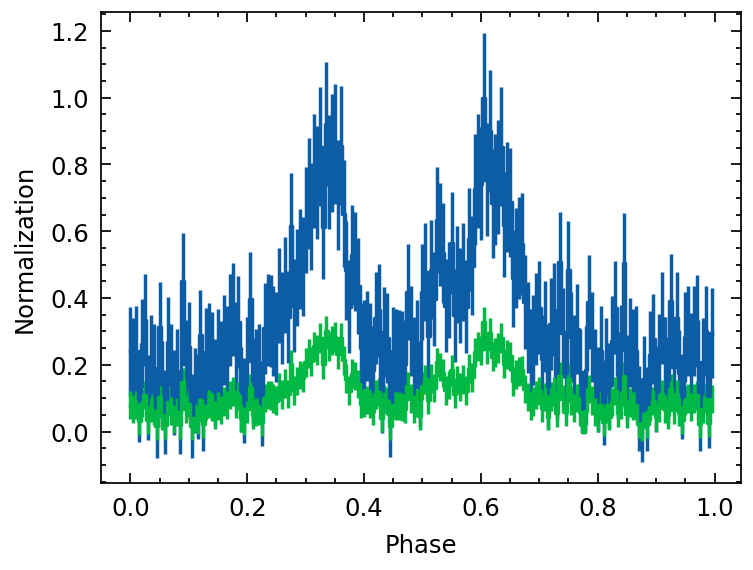

In [13]:
from copy import deepcopy

profile_tmp = deepcopy(profile)
profile_tmp.norm(method=0) # Normalization

plt.errorbar(profile_tmp.phase, profile_tmp.counts,
             yerr=profile_tmp.error, ds='steps-mid')

profile_tmp = deepcopy(profile)
profile_tmp.norm(method=1) # Normalization

# plt.twinx()
plt.errorbar(profile_tmp.phase, profile_tmp.counts,
             yerr=profile_tmp.error, ds='steps-mid')
plt.xlabel("Phase")
plt.ylabel("Normalization")

### Sampling
Here we address a specific simulation scenario. Suppose we have a pulse profile, and our goal is to simulate an event list that begins at `tstart` and concludes at `tstop`.

We possess knowledge of the pulsar's timing parameters, and for the purpose of this exercise, we will employ the parameters of the Crab Pulsar as our timing model. The objective is to generate a sequence of photon arrival times that aligns with these predefined timing parameters.

In [40]:
profile_init = draw_random_pulse(nbins=200, baseline=100000, pulsefrac=0.5)

nphot = 2000 # Number of photons to draw
tstart = 59000 # Start time of simulated event list
tstop  = 60000 # Stop time of simulated event list
f0 = par.f0
f1 = par.f1
f2 = par.f2

pepoch = int(par.t0geo)


event_list = profile_init.sampling_event(nphot=nphot,
                                             tstart=tstart,
                                             tstop=tstop,
                                             f0=f0, f1=f1, f2=f2,
                                             pepoch=pepoch)

100%|████████████████████████████████████████████████████████████████████████| 1061/1061 [00:00<00:00, 108068.59it/s]


/Users/tuoyouli/Work/SoftwareDev/tatpulsar/tat-pulsar_main/tatpulsar/data/profile.py:343: RuntimeWarning: divide by zero encountered in true_divide
  norm_error = expression * np.sqrt((delta_num / (X - m))**2 + (delta_den / (M - m))**2)
/Users/tuoyouli/Work/SoftwareDev/tatpulsar/tat-pulsar_main/tatpulsar/data/profile.py:343: RuntimeWarning: invalid value encountered in multiply
  norm_error = expression * np.sqrt((delta_num / (X - m))**2 + (delta_den / (M - m))**2)


Text(0, 0.5, 'Normalized flux')

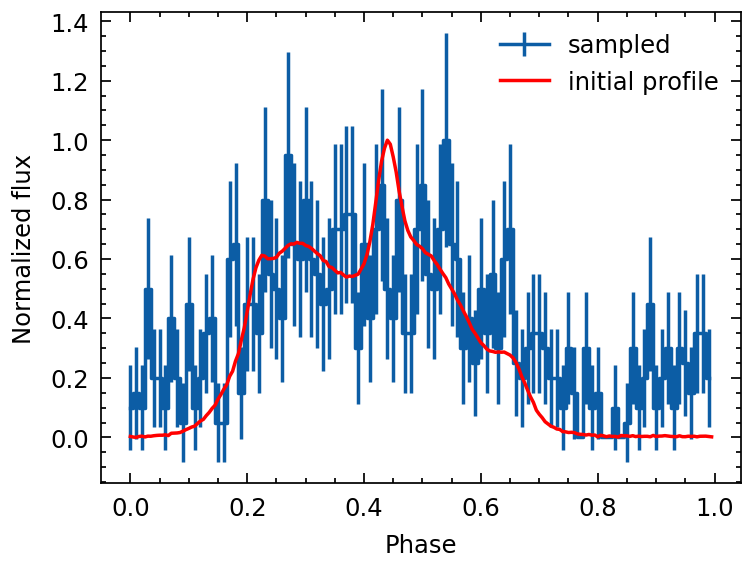

In [41]:
profile_sampled = fold(event_list,
                       pepoch=pepoch, f0=f0, f1=f1, f2=f2,
                       nbins=100, format='mjd')
profile_sampled.norm()
profile_init.norm()
plt.errorbar(profile_sampled.phase, profile_sampled.counts, 
             profile_sampled.error, ds='steps-mid', label='sampled')
plt.errorbar(profile_init.phase, profile_init.counts, c='r', label='initial profile')
plt.legend()
plt.xlabel("Phase")
plt.ylabel("Normalized flux")

## 

100%|███████████████████████████████████████████████████████████████████████████| 541/541 [00:00<00:00, 87526.27it/s]


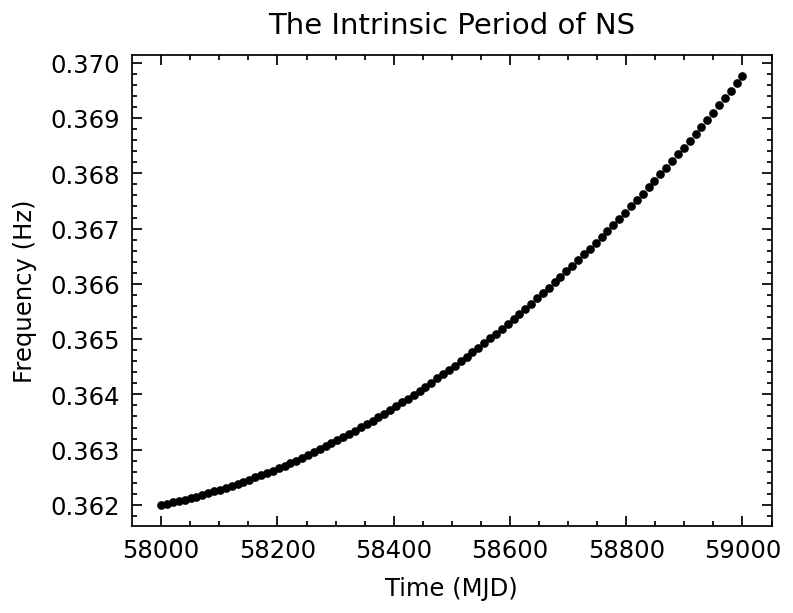

<ErrorbarContainer object of 3 artists>

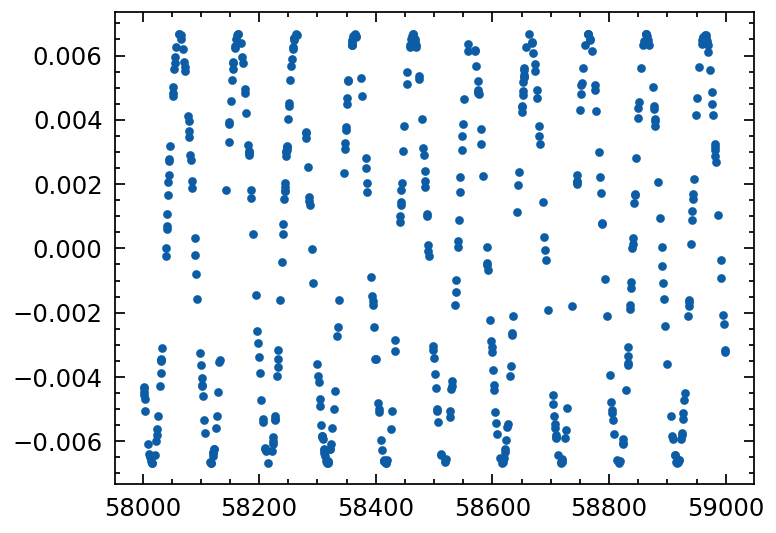

In [61]:
plt.errorbar(observed_times, delta_t, fmt='.')

In [62]:
from tatpulsar.pulse.binary import orbit_cor_kepler
t_em = orbit_cor_kepler(emission_times, Tw=fake_T_halfpi,
                        ecc=fake_e,
                        Porb = fake_Porb*86400,
                        omega=fake_omega,
                        axsini=fake_axsini)

<ErrorbarContainer object of 3 artists>

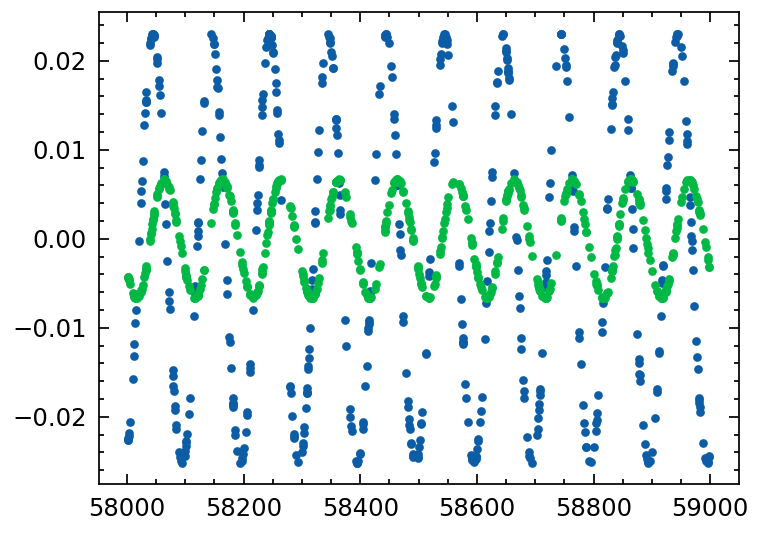

In [64]:
plt.errorbar(observed_times, t_em-observed_times, fmt='.')
plt.errorbar(observed_times, delta_t, fmt='.')